In [ ]:
pip install opendatasets

In [ ]:
import os
import opendatasets as od
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
import numpy as np
from PIL import Image

In [ ]:
od.download("https://www.kaggle.com/datasets/elneea/stellarimages1")
# {"username":"elneea","key":"71427e85792347ccbecc4837b0137b9b"}

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: elneea
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/elneea/stellarimages1


100%|██████████| 2.02M/2.02M [00:00<00:00, 182MB/s]

In [ ]:
def load_images_folder(root, folders):
    all_images = []
    all_labels = []
    label_map = {folder: i for i, folder in enumerate(folders)}  # Assign labels
    for folder in folders:
        folder_path = os.path.join(root, folder)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            if filename.endswith(('jpg', 'jpeg', 'png', 'bmp')):
                all_images.append(img_path)
                all_labels.append(label_map[folder])
    return all_images, all_labels

In [ ]:
df = pd.read_csv("/content/star_classification.csv")
df_galaxies = df.loc[df['class'] == 'GALAXY'][:500]
df_stars = df.loc[df['class'] == 'STAR'][:500]
df_qso = df.loc[df['class'] == 'QSO'][:500]
df_galaxies.reset_index(drop=True, inplace=True)
df_stars.reset_index(drop=True, inplace=True)
df_qso.reset_index(drop=True, inplace=True)
df_all = df_stars._append(df_qso,ignore_index=True)
df = df_all._append(df_galaxies,ignore_index=True)

In [ ]:
image_folder = '/content/stellarimages1/images'

class_mapping = {label: idx for idx, label in enumerate(df['class'].unique())}
df['label'] = df['class'].map(class_mapping)

### create a dictionary to accommodate the dataset
dataset_list = [
    {
        "image_path": os.path.join(image_folder, f"{str(row['obj_ID'])}.jpg"),
        "label": row['label']
    }
    for _, row in df.iterrows()
]

In [ ]:
image_paths = [item['image_path'] for item in dataset_list]
labels = np.array([item['label'] for item in dataset_list])

def load_and_preprocess_image(img_path):
    try:
      image = Image.open(img_path).convert("RGB")
      image = image.resize((224, 224))
      image = np.array(image) / 255.0
      return image
    except FileNotFoundError:
      print(f"Skipping index {img_path} due to FileNotFoundError")

images = np.array([load_and_preprocess_image(img_path) for img_path in image_paths])
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.3),
])

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(3, activation="softmax")(x)

model = models.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), batch_size=64, epochs=30)

# Optimizer choicess: adam, SGD, optimizer=keras.optimizers.RMSprop(learning_rate=0.05)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.4709 - loss: 1.2742 - val_accuracy: 0.6267 - val_loss: 0.8612
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.6710 - loss: 0.7951 - val_accuracy: 0.7067 - val_loss: 0.7597
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7083 - loss: 0.7093 - val_accuracy: 0.7433 - val_loss: 0.7288
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.7270 - loss: 0.6593 - val_accuracy: 0.7000 - val_loss: 0.7365
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7370 - loss: 0.6552 - val_accuracy: 0.7367 - val_loss: 0.7280
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7443 - loss: 0.6420 - val_accuracy: 0.7300 - val_loss: 0.7590
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7401 - loss: 0.6290 - val_accuracy: 0.7500 - val_loss: 0.6536
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.7479 - loss: 0.5965 - val_accuracy: 0.

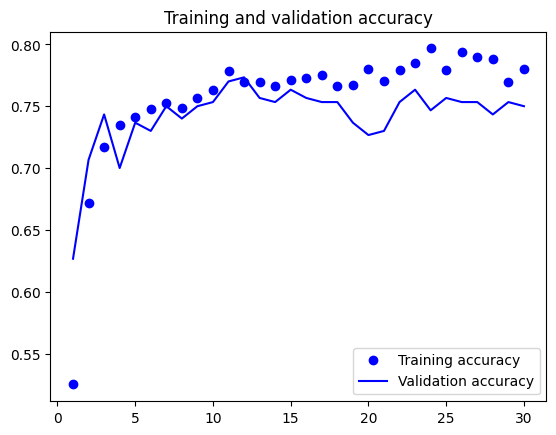

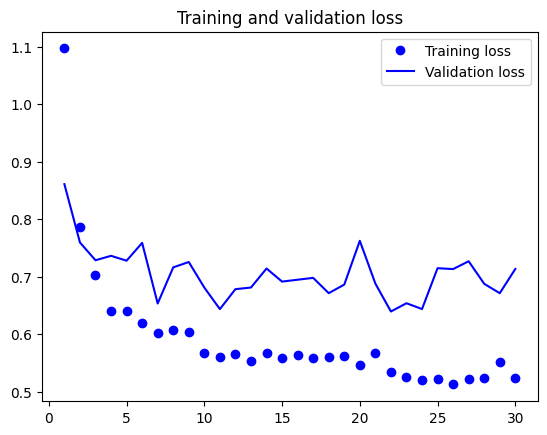

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
from prettytable import PrettyTable

myTable = PrettyTable(["Optimizer", "Num Layers", "Batch Size", "Optimal Epochs", "Training Accuracy", "Test Accuracy"])

myTable.add_row(["Adam", "3","32","","",""])

print(myTable)

+-----------+------------+------------+----------------+-------------------+---------------+
| Optimizer | Num Layers | Batch Size | Optimal Epochs | Training Accuracy | Test Accuracy |
+-----------+------------+------------+----------------+-------------------+---------------+
|    Adam   |     3      |     32     |                |                   |               |
+-----------+------------+------------+----------------+-------------------+---------------+
